#Import Libraries and Data

First install all neccessary libraries and packages

In [ ]:
!pip install -U seaborn
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install nltk
!pip install nltk
import nltk
from bs4 import BeautifulSoup 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
!pip install pywaffle
from pywaffle import Waffle
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

Requirement already up-to-date: seaborn in /usr/local/lib/python3.7/dist-packages (0.11.1)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#data mounted from Google Drive - change directories according to your G Drive
from google.colab import drive  
drive.mount('/content/gdrive');
canadian_elections_directory = 'gdrive/My Drive/Colab Notebooks/MIE1624/Assignment 3/Canadian_elections_2019.csv';
sentiment_directory = 'gdrive/My Drive/Colab Notebooks/MIE1624/Assignment 3/sentiment_analysis.csv';

elec_df = pd.read_csv(canadian_elections_directory)
sent_df = pd.read_csv(sentiment_directory)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
elec_df.describe()

,sentiment,negative_reason,text
count,2133,1007,2133
unique,2,10,2133
top,positive,Others,"b""#ICYMI - #Analysis - How will Ford Nation re..."
freq,1127,365,1


In [ ]:
elec_df.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [ ]:
sent_df

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [ ]:
sent_df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


We can see the text in the tweets are not in a form amenable to analysis. There is too much noise in the form of HTML tags, character codes, URLS, stop words, capitalization etc. We will pre-process the text such that it is cleaned in order for out model to be able to interpret effectively. 

#Data Cleaning

- We use the NLTK resource for stopwords however there are a few we will not consider stop words such as 'no' or hasn't because they have a negative connotation that could help distinguish sentiment. 
- HTML tags are removed and all HTML character codes are replaced with ASCII equivalent
-Remove all URLS from the text as they do not contribute to sentiment 
- we will make all words in lower case since we don't want to increase features based on capitalization as this will worsten our model
- Replace emoji symbols based on their sentiment. So a happy emoji will be replaced by the string 'goodemo' while negative emojis will be replaced by 'bademo' in order to keep their sentiment meaning.
- All our text are contained as one long string. We will tokenize such that each word is it's own string and remove any words that are less than 1 letter.
- Lemmatize the words in order to group together words with the same root meaning improving model performance and decreasing the number of features. 


In [ ]:
stop_words = stopwords.words('english')
not_stopword = ['no', 'not', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", "wasn't"]
for word in not_stopword:
    stop_words.remove(word)

def remove_HTML(text):
    clean_text = BeautifulSoup(text).get_text()
    return clean_text

def HTML_to_ASCII(text):
    text.encode('ascii', 'xmlcharrefreplace')
    return text

def remove_URL(text):
    text = re.sub(r"http\S+", "", text)
    return text

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

happy_emojis = [':)', ':D', ":')", ':")', 'xD', 'XD', '8D', ':P', '=D', '=)', '=P', "=')", '=")',":‑)",": )",":-]",":]",":-3",
               ":3",":->",":>","8-)","8)",":-}",":}",":o)",":c)",":^)", "=]", "=)"]
			
sad_emojis = [':(', 'D:', ":'(", ':"(', 'Dx', 'DX', ':(', "D‑':","D:<","D:","D8","D;","D=", ":‑|",":|",":$", ":E", ">_>", "<_<",
             ";(", ":-||", ":c", ":-c",":-(",":-<",":<",":[",":-[", ":-[",">:[",">:("]

def translate_emojis(text):
    updated_text = []
    words = text.split()
    for word in words:
        if word in happy_emojis:
            w = 'goodemo'
        elif word in sad_emojis:
            w = 'bademo'
        else:
            w = word
        updated_text.append(w)
    return str(updated_text)


def text_cleaning(text):
    text = re.sub('^b"', '',text)
    text = re.sub("^b'", '', text)
    text = remove_URL(text)
    text = translate_emojis(text)
    text = re.sub('([^A-Z0-9a-z\s]+)', ' ', text)  
    text = re.sub('@[A-Z0-9a-z]+|#[A-Z0-9a-z]', '', text)
    text = re.sub('\.|\,|\?|\!|-|_','', text)
    text = remove_HTML(text)
    text = HTML_to_ASCII(text)
    text = text.lower()
    text = re.sub('rt', '',text)
    text = word_tokenize(text)
    text = [word for word in text if not word in stop_words]
    text = [word for word in text if len(word) >1]
    text = lemmatize(text)


    return text



Apply the text pre-processing to both the elections and generic tweet datasets and store the cleaned text as a new column in the DataFrame. 

In [ ]:
elec_df['text_cleaned'] = elec_df['text'].apply(lambda x: text_cleaning(x))
sent_df['text_cleaned'] = sent_df['text'].apply(lambda x: text_cleaning(x))


In [ ]:
sent_df['text_cleaned'][1]

['mianusmanjaved',
 'congratulation',
 'pakistan',
 'becoming',
 'no1testteam',
 'world',
 'odds',
 'ji',
 'pakzindabadrallies']

#Exploratory Analysis Elections 2019 Data

Let's look at the distribution of negative and positive sentiment tweets for the Canada 2019 Elections data.

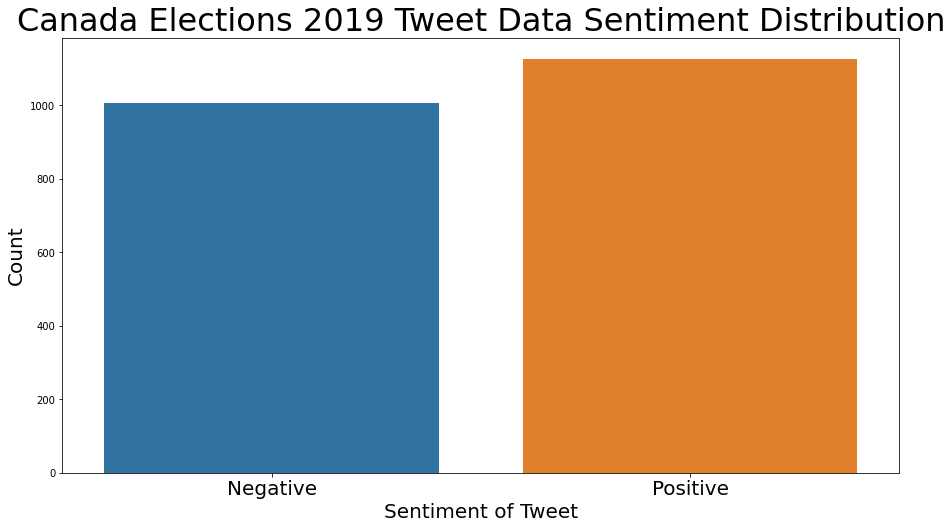

In [ ]:
elec_df['label'] = elec_df.sentiment.apply(lambda x: 1 if x == 'positive' else 0)

plt.figure(figsize = (15,8))
fig = sns.countplot(data = elec_df, x = 'label')
fig.set_title('Canada Elections 2019 Tweet Data Sentiment Distribution', fontsize = 32)
fig.set_xticklabels(['Negative', 'Positive'], fontsize = 20)
fig.set_xlabel('Sentiment of Tweet', fontsize = 20)
fig.set_ylabel('Count', fontsize = 20);

As shown above there are roughly the same number of negative and positive sentiment tweets with their being slightly more positive ones. It would be interesting to know how these distributions differ between tweets targeted at different political parties. We will devise a procedure to determine the political party (Liberal, Conservative, NDP) of a given tweet and apply this procedure to all tweets in the elections dataset. 

By exploring the tweets in the dataset we can compile a list of keywords, hashtags, twitter handles which relate to certain political parties and store them in a list of keywords. 

We then calculate the number of keywords a tweet contains for each political party and use that to assign a political party to a tweet. Note if there are ties we assign a mutual party (i.e. Conservative & Liberal Tweet). 

In [ ]:
con_kw = ['conservative', 'gunlobby', 'cpc', 'lyingandy', 'andrewscheer', 'scheer4pm', 'scheer', 'anxiousandrew', 'maximebernier', 'blue']
lib_kw = ['justin','trudeaumustgo', 'snclavalinscandal','voteliberal','chooseforward','cpckinsellagate', 'trudeau', 'liberal', 'red', 'representation',
          'representationmatters', 'kinsella', 'warren', 'warrenkinsella']
ndp_kw = ['uprisingh', 'ndp', 'jagmeetsingh', 'jagmeet', 'singh', 'orange']

def get_party_score(text):
    con_score = np.sum([1 if s in con_kw else 0 for s in text])
    lib_score = np.sum([1 if s in lib_kw else 0 for s in text])
    ndp_score = np.sum([1 if s in ndp_kw else 0 for s in text])

    if con_score+lib_score+ndp_score == 0:
        return str([0,0,0])
       
    return str(np.where([con_score, lib_score, ndp_score] == np.max([con_score, lib_score, ndp_score]))[0])

 

Apply the procedure to the dataset

In [ ]:
elec_df['party_score'] = elec_df['text_cleaned'].apply(lambda x: get_party_score(x))

Display the results

In [ ]:
no_party, conservative, liberal, ndp, con_lib, con_ndp, lib_ndp, con_lib_ndp = elec_df['party_score'].value_counts()
party_score = {'No Party Affiliation': no_party, 'Conservative': conservative, 'Liberal': liberal, 'NDP':ndp, 'Conservative & Liberal': con_lib, 'Conservative & NDP': con_ndp, 'Liberal & NDP': lib_ndp, 'Conservative & Liberal & NDP': con_lib_ndp}
party_score

{'Conservative': 470,
 'Conservative & Liberal': 105,
 'Conservative & Liberal & NDP': 14,
 'Conservative & NDP': 19,
 'Liberal': 436,
 'Liberal & NDP': 19,
 'NDP': 124,
 'No Party Affiliation': 946}

Most tweets are not associated with a political party. The most popular were of conservatives then liberals and then NDP. There were some tweets that were about more than one political party with the most common being Conservative & Liberal.

<Figure size 2160x1800 with 0 Axes>

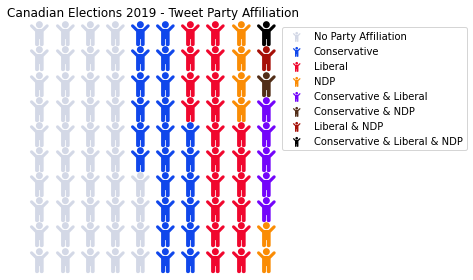

In [ ]:
plt.figure(figsize=(30,25));
fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, columns = 10,
    values=party_score, 
    colors=("#d3d8e6","#1047eb", "#f0072e", "#fa8c05", "#7305fa", "#522e18", "#a61008", "#000000"),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons= 'child', icon_size=25, 
    icon_legend=True,
    font_size = 24,
);
plt.title('Canadian Elections 2019 - Tweet Party Affiliation');

#Exploratory Analysis Generic Tweet Data

In [ ]:
sent_df.head()

,ID,text,label,text_cleaned
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, looking, forward, tab, breeder..."
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[mianusmanjaved, congratulation, pakistan, bec..."
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,"[pepales, september, yesmag, taking, maine, me..."
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[david, gaibis, newly, painted, wall, thanks, ..."
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,"[cedricfeschotte, excited, announce, july, 201..."


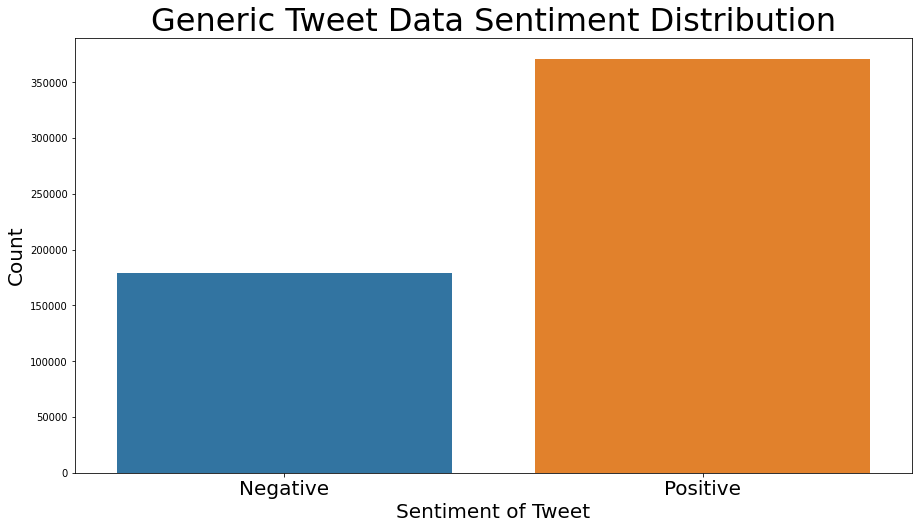

In [ ]:
plt.figure(figsize = (15,8))
fig = sns.countplot(data = sent_df, x = 'label')
fig.set_title('Generic Tweet Data Sentiment Distribution', fontsize = 32)
fig.set_xticklabels(['Negative', 'Positive'], fontsize = 20)
fig.set_xlabel('Sentiment of Tweet', fontsize = 20)
fig.set_ylabel('Count', fontsize = 20);



We can see the majority of our generic tweets have positive sentiments with less than half negative sentiment. Next we will create a word map to see if there are any frequent keywords between the negative and positive sentiment groups. 

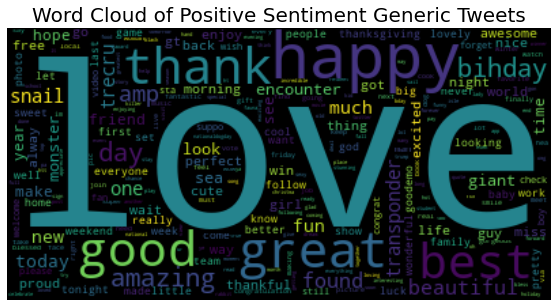

In [ ]:
pos_generic_tweets = sent_df['text_cleaned'][sent_df['label']==1]
tweets_string_pos = []
for sentence in pos_generic_tweets:
    for word in sentence:
        tweets_string_pos.append(word)
tweets_string_pos = pd.Series(tweets_string_pos).str.cat(sep=' ')

wordcloud_sen = WordCloud(max_font_size=250, max_words=250, collocations= False, background_color = 'black').generate(tweets_string_pos)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_sen, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Positive Sentiment Generic Tweets', fontsize = 20)
plt.show()

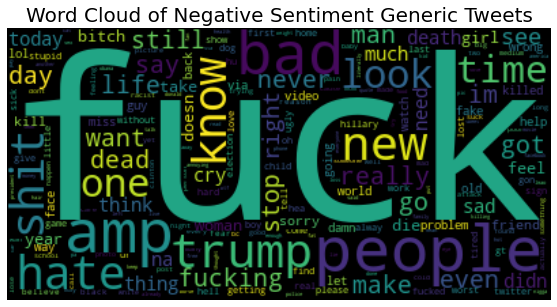

In [ ]:
neg_generic_tweets = sent_df['text_cleaned'][sent_df['label']==0]
tweets_string_neg = []
for sentence in neg_generic_tweets:
    for word in sentence:
        tweets_string_neg.append(word)
tweets_string_neg = pd.Series(tweets_string_neg).str.cat(sep=' ')

wordcloud_sen = WordCloud(max_font_size=250, max_words=250, collocations= False, background_color = 'black').generate(tweets_string_neg)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_sen, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Negative Sentiment Generic Tweets', fontsize = 20)
plt.show()

## Model Preparation & Implementation: Generic Tweet Data



We will now train models using our generic tweet dataset which has already been cleaned. First we will split into 70% training and 30% test. We want to split the data before vectorizing since we would have information leakage if we included the test data. This is because we will introduce words from the test set in the dictionary of words from vectorizing that otherwise may not exist in the training set. Hence our model has in a sense 'seen' the test data in a way so the performance will be overestimated than if applied to truly 'unseen' data. 

In [ ]:
X = sent_df.text_cleaned
y = sent_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

###Bag of Words

Use count vectorizer to transform data into bag of words. Since we have a very large number of total words from all our tweets we will set the max_features parameter to cap this to decrease computation time. This parameter will consider the top features based on term freuqency and so we are essentially keeping only the most important words while reducing dimensionality of our dataset. We will use 1000 features which are the top most relevant words. This will keep the features that are the most important while also reducing the noise and removing random words that are not relevant or even words at all that made it from the cleaning step earlier. 

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",ngram_range = (1,1), max_features = 1000, strip_accents = 'ascii') 
vectorizer.fit([' '.join(arr) for arr in X_train])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
bag_of_words_train = vectorizer.transform([' '.join(arr) for arr in X_train])
bag_of_words_test = vectorizer.transform([' '.join(arr) for arr in X_test])

####1. Logistic Regression

We choose L2 regularization since we have a very large number of features each with small/medium affect. We choose C = 0.01 such that we have a high regulzarization in the model and we prevent overfitting. We choose the SAGA solver as it is best for sparse matrices and is suitable for large datasets.

In [ ]:
#train the Logistic Regression model on the training data
log_reg_bow = LogisticRegression(C = 0.01, solver = 'saga', penalty = 'l2')
log_reg_bow.fit(bag_of_words_train, y_train)

#Predict test labels using the model
log_bow_test_pred = log_reg_bow.predict(bag_of_words_test)

#Calculate accuracy, precision and recall of the test set
log_bow_test_acc = accuracy_score(y_test,log_bow_test_pred)
print('The accuracy using Logistic Regression with BoW on the test set is:', 100*np.round(log_bow_test_acc,4), '%')
log_bow_test_prec = precision_score(y_test,log_bow_test_pred)
print('The precision using Logistic Regression with BoW on the test set is:', 100*np.round(log_bow_test_prec,4), '%')
log_bow_test_rec = recall_score(y_test,log_bow_test_pred)
print('The recall using Logistic Regression with BoW on the test set is:', 100*np.round(log_bow_test_rec,4), '%')


The accuracy using Logistic Regression with BoW on the test set is: 93.62 %
The precision using Logistic Regression with BoW on the test set is: 96.22 %
The recall using Logistic Regression with BoW on the test set is: 94.26 %


####k-NN Classification

Our data has gone through Count Vectorizer so the resulting matrix is 1's and 0's therefore we don't require scaling. We leave the solver method on 'auto' to detect the most appropriate algorithm for the input. It will likely be Brute Force algorithm since it is a large and sparce dataset. The number of neighbors has been left at the default of 5 as with the remaining hyperparameters. the max feature we selected in our vectorizer ensures we converge in a reasonable time. K neighbor model is typically not efficient for large datasets since we have to calculate distances between all points so we expect this algorithm to take long to finish running. 

In [ ]:
knn_bow = KNeighborsClassifier(algorithm='brute')
knn_bow.fit(bag_of_words_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#Calculate accuracy score of the training and test set
knn_test_pred =  knn_bow.predict(bag_of_words_test)
knn_bow_test_acc = accuracy_score(y_test,knn_test_pred)
print('The accuracy using kNN Classification with BoW on the test set is:', 100*np.round(knn_bow_test_acc,4), '%')
knn_bow_test_prec = precision_score(y_test,knn_test_pred)
print('The precision using kNN Classification with BoW on the test set is:', 100*np.round(knn_bow_test_prec,4), '%')
knn_bow_test_rec = recall_score(y_test,knn_test_pred)
print('The recall using Logistic Regression with BoW on the test set is:', 100*np.round(knn_bow_test_rec,4), '%')


The accuracy using kNN Classification with BoW on the test set is: 91.18 %
The precision using kNN Classification with BoW on the test set is: 96.34 %
The recall using Logistic Regression with BoW on the test set is: 90.38000000000001 %


####Naive Bayes

We will use Linear SVM since we have such a large sparse matrix and we want faster convergence. Additionally we will increase the max number of iterations to 4000 to ensure convergence. In general SVM are efficient for large datasets such as the one we have.

In [ ]:
svm_linear_bow = LinearSVC(max_iter = 4000)

svm_linear_bow.fit(bag_of_words_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svm_linear_bow_test_pred = svm_linear_bow.predict(bag_of_words_test)

svm_linear_bow_test_acc = accuracy_score(y_test, svm_linear_bow_test_pred)
print('The accuracy using Naive Bayes Classification with BoW on the test set is:', 100*np.round(svm_linear_bow_test_acc,4), '%')
svm_linear_bow_test_prec = precision_score(y_test,svm_linear_bow_test_pred)
print('The precision using Naive Bayes Classification with BoW on the test set is:', 100*np.round(svm_linear_bow_test_prec,4), '%')
svm_linear_bow_test_rec = recall_score(y_test,svm_linear_bow_test_pred)
print('The recall using Naive Bayes with BoW on the test set is:', 100*np.round(svm_linear_bow_test_rec,4), '%')


The accuracy using Naive Bayes Classification with BoW on the test set is: 94.1 %
The precision using Naive Bayes Classification with BoW on the test set is: 96.93 %
The recall using Naive Bayes with BoW on the test set is: 94.25 %


####Decision Trees

We will use the default hyperparameters for decision trees which includes no max depth so the tree will be expanded until all leaves contain less than 2 samples. The max features is also left as default to equal to the number of features in order to give the best model. This will result in the model running slightly longer however we will get much better results.  

In [ ]:
trees_bow = DecisionTreeClassifier()
trees_bow.fit(bag_of_words_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
trees_bow_test_pred = trees_bow.predict(bag_of_words_test)

trees_bow_test_acc = accuracy_score(y_test, trees_bow_test_pred)
print('The accuracy using Decision Trees Classification with BoW on the test set is:', 100*np.round(trees_bow_test_acc,4), '%')
trees_bow_test_prec = precision_score(y_test,trees_bow_test_pred)
print('The precision using Decision Trees Classification with BoW on the test set is:', 100*np.round(trees_bow_test_prec,4), '%')
trees_bow_test_rec = recall_score(y_test,trees_bow_test_pred)
print('The recall using Decision Trees with BoW on the test set is:', 100*np.round(trees_bow_test_rec,4), '%')

The accuracy using Decision Trees Classification with BoW on the test set is: 92.7 %
The precision using Decision Trees Classification with BoW on the test set is: 95.05 %
The recall using Decision Trees with BoW on the test set is: 94.1 %


####Random Forest

For random forest which is essentially an ensemble of decision trees we will set the number of estimators (trees) to be 200. This will allow us to get good results while not being hugely computationally expensive. We will leave the max depth of each tree and max leaf nodes as default so they are the same as the decision trees from the previous section. We will leave the bootstrapping as default which is True to speed up the computation given it is a very large, sparse dataset. 

In [ ]:
ran_forest_bow = RandomForestClassifier(n_estimators=200, )
ran_forest_bow.fit(bag_of_words_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
ran_forest_bow_test_pred = ran_forest_bow.predict(bag_of_words_test)

ran_forest_bow_test_acc = accuracy_score(y_test, ran_forest_bow_test_pred)
print('The accuracy using Naive Bayes Classification with BoW on the test set is:', 100*np.round(ran_forest_bow_test_acc,4), '%')
ran_forest_bow_test_prec = precision_score(y_test,ran_forest_bow_test_pred)
print('The precision using Naive Bayes Classification with BoW on the test set is:', 100*np.round(ran_forest_bow_test_prec,4), '%')
ran_forest_bow_test_rec = recall_score(y_test,ran_forest_bow_test_pred)
print('The recall using Naive Bayes with BoW on the test set is:', 100*np.round(ran_forest_bow_test_rec,4), '%')

The accuracy using Naive Bayes Classification with BoW on the test set is: 94.17 %
The precision using Naive Bayes Classification with BoW on the test set is: 96.21 %
The recall using Naive Bayes with BoW on the test set is: 95.12 %


####XG Boost

For XG Boost (gradient boosted decision trees) we will set the max depth equal to 30 to match the decision trees and random forest from before. The number of classes is equal to 2 given there are either positive or negative labels. We will set the eta to 0.2 to prevent overfitting by shrinking the feature weights. 

In [ ]:
dtrain = xgb.DMatrix(bag_of_words_train, label=y_train)
dtest = xgb.DMatrix(bag_of_words_test, label=y_test)
param = {
    'max_depth': 30,  # the maximum depth of each tree
    'eta': 0.2,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}
num_round = 20 #number of training

xgb_bow = xgb.train(param, dtrain, num_round)

In [ ]:
xgb_bow_test_prob_pred = xgb_bow.predict(dtest)
xgb_bow_test_pred = np.argmax(xgb_bow_test_prob_pred, axis = 1)

xgb_bow_test_acc = accuracy_score(y_test, xgb_bow_test_pred)
print('The accuracy using xGB with BoW on the test set is:', 100*np.round(xgb_bow_test_acc,4), '%')
xgb_bow_test_prec = precision_score(y_test,xgb_bow_test_pred)
print('The precision using xGB with BoW on the test set is:', 100*np.round(xgb_bow_test_prec,4), '%')
xgb_bow_test_rec = recall_score(y_test,xgb_bow_test_pred)
print('The recall using xGB with BoW on the test set is:', 100*np.round(xgb_bow_test_rec,4), '%')


The accuracy using xGB with BoW on the test set is: 91.41 %
The precision using xGB with BoW on the test set is: 97.82 %
The recall using xGB with BoW on the test set is: 89.28 %


xGB had better results using only a max depth of 20 compared to the Random Forest classifier which had an unlimited max depth. It also loads much faster.

###TF-IDF

Use Tfidf vectorizer to transform data into TF-IDF. Since we have a very large number of total words from all our tweets we will set the max_features parameter to cap this to decrease computation time. This parameter will consider the top features based on term frequency and so we are essentially keeping only the most important words while reducing dimensionality of our dataset. 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, strip_accents='ascii', analyzer='word', ngram_range=(1,1))
tfidf_vectorizer.fit([' '.join(arr) for arr in X_train])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
tfidf_train = tfidf_vectorizer.transform([' '.join(arr) for arr in X_train])
tfidf_test = tfidf_vectorizer.transform([' '.join(arr) for arr in X_test])

We will not implement the same models as discussed before but on the TFIDF dataset.

####Logistic Regression

We will use C = 0.01 for the inverse regularization parameter to prevent overfitting. We choose L2 regularization since we have a very large number of features each with small/medium affect. We choose the SAGA solver as it is best for sparse matrices and is suitable for large datasets.

In [ ]:
#train the Logistic Regression model on the training data
log_reg_tfidf = LogisticRegression(C = 0.01, solver = 'saga', penalty = 'l2')
log_reg_tfidf.fit(tfidf_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Predict test labels using the model
log_tfidf_test_pred = log_reg_tfidf.predict(tfidf_test)

#Calculate accuracy, precision and recall of the test set
log_tfidf_test_acc = accuracy_score(y_test,log_tfidf_test_pred)
print('The accuracy using Logistic Regression with TF-IDF on the test set is:', 100*np.round(log_tfidf_test_acc,4), '%')
log_tfidf_test_prec = precision_score(y_test,log_tfidf_test_pred)
print('The precision using Logistic Regression with TF-IDF on the test set is:', 100*np.round(log_tfidf_test_prec,4), '%')
log_tfidf_test_rec = recall_score(y_test,log_tfidf_test_pred)
print('The recall using Logistic Regression with TF-IDF on the test set is:', 100*np.round(log_tfidf_test_rec,4), '%')


The accuracy using Logistic Regression with TF-IDF on the test set is: 92.32000000000001 %
The precision using Logistic Regression with TF-IDF on the test set is: 92.51 %
The recall using Logistic Regression with TF-IDF on the test set is: 96.44 %


####k-NN Classification

We will use the default parameters for kNN algorithm which is 5 nearest neighbors. Our TFIDF matrix like our BoW matrix is large and sparse and so we expect the model to take a long time to finish running like before. 

In [ ]:
knn_tfidf = KNeighborsClassifier(algorithm='brute')
knn_tfidf.fit(tfidf_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#Calculate accuracy score of the training and test set
knn_tfidf_test_pred =  knn_tfidf.predict(tfidf_test)
knn_tfidf_test_acc = accuracy_score(y_test,knn_tfidf_test_pred)
print('The accuracy using kNN Classification with TF-IDF on the test set is:', 100*np.round(knn_tfidf_test_acc,4), '%')
knn_tfidf_test_prec = precision_score(y_test,knn_tfidf_test_pred)
print('The precision using kNN Classification with TF-IDF on the test set is:', 100*np.round(knn_tfidf_test_prec,4), '%')
knn_tfidf_test_rec = recall_score(y_test,knn_tfidf_test_pred)
print('The recall using Logistic Regression with TF-IDF on the test set is:', 100*np.round(knn_tfidf_test_rec,4), '%')


The accuracy using kNN Classification with TF-IDF on the test set is: 86.85000000000001 %
The precision using kNN Classification with TF-IDF on the test set is: 93.88 %
The recall using Logistic Regression with TF-IDF on the test set is: 86.17 %


####Naive Bayes

We will use Linear SVM since we have such a large sparse matrix and we want faster convergence. Additionally we will increase the max number of iterations to 4000 to ensure convergence. In general SVM are efficient for large datasets such as the one we have.

In [ ]:
#svm_linear_tfidf = SVC()
svm_linear_tfidf = LinearSVC(max_iter = 4000)

svm_linear_tfidf.fit(tfidf_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=4000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svm_linear_tfidf_test_pred = svm_linear_tfidf.predict(tfidf_test)

svm_linear_tfidf_test_acc = accuracy_score(y_test, svm_linear_tfidf_test_pred)
print('The accuracy using Naive Bayes Classification with TF-IDF on the test set is:', 100*np.round(svm_linear_tfidf_test_acc,4), '%')
svm_linear_tfidf_test_prec = precision_score(y_test,svm_linear_tfidf_test_pred)
print('The precision using Naive Bayes Classification with TF-IDF on the test set is:', 100*np.round(svm_linear_tfidf_test_prec,4), '%')
svm_linear_tfidf_test_rec = recall_score(y_test,svm_linear_tfidf_test_pred)
print('The recall using Naive Bayes with TF-IDF on the test set is:', 100*np.round(svm_linear_tfidf_test_rec,4), '%')


The accuracy using Naive Bayes Classification with TF-IDF on the test set is: 94.15 %
The precision using Naive Bayes Classification with TF-IDF on the test set is: 96.54 %
The recall using Naive Bayes with TF-IDF on the test set is: 94.73 %


####Decision Trees

We will use the default hyperparameters for decision trees which includes no max depth so the tree will be expanded until all leaves contain less than 2 samples. The max features is also left as default to equal to the number of features in order to give the best model. This will result in the model running slightly longer however we will get much better results.  

In [ ]:
trees_tfidf = DecisionTreeClassifier()
trees_tfidf.fit(tfidf_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
trees_tfidf_test_pred = trees_tfidf.predict(tfidf_test)

trees_tfidf_test_acc = accuracy_score(y_test, trees_tfidf_test_pred)
print('The accuracy using Decision Trees Classification with TF-IDF on the test set is:', 100*np.round(trees_tfidf_test_acc,4), '%')
trees_tfidf_test_prec = precision_score(y_test,trees_tfidf_test_pred)
print('The precision using Decision Trees Classification with TF-IDF on the test set is:', 100*np.round(trees_tfidf_test_prec,4), '%')
trees_tfidf_test_rec = recall_score(y_test,trees_tfidf_test_pred)
print('The recall using Decision Trees with TF-IDF on the test set is:', 100*np.round(trees_tfidf_test_rec,4), '%')

The accuracy using Decision Trees Classification with TF-IDF on the test set is: 92.86999999999999 %
The precision using Decision Trees Classification with TF-IDF on the test set is: 95.27 %
The recall using Decision Trees with TF-IDF on the test set is: 94.12 %


####Random Forest

For random forest which is essentially an ensemble of decision trees we will set the number of estimators (trees) to be 200. This will allow us to get good results while not being hugely computationally expensive. We will leave the max depth of each tree and max leaf nodes as default so they are the same as the decision trees from the previous section. We will leave the bootstrapping as default which is True to speed up the computation given it is a very large, sparse dataset. 

In [ ]:
ran_forest_tfidf = RandomForestClassifier()
ran_forest_tfidf.fit(tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
ran_forest_tfidf_test_pred = ran_forest_tfidf.predict(tfidf_test)

ran_forest_tfidf_test_acc = accuracy_score(y_test, ran_forest_tfidf_test_pred)
print('The accuracy using Random Forest with TF-IDF on the test set is:', 100*np.round(ran_forest_tfidf_test_acc,4), '%')
ran_forest_tfidf_test_prec = precision_score(y_test,ran_forest_tfidf_test_pred)
print('The precision using Random Forest with TF-IDF on the test set is:', 100*np.round(ran_forest_tfidf_test_prec,4), '%')
ran_forest_tfidf_test_rec = recall_score(y_test,ran_forest_tfidf_test_pred)
print('The recall using Random Forest with TF-IDF on the test set is:', 100*np.round(ran_forest_tfidf_test_rec,4), '%')

The accuracy using Random Forest with TF-IDF on the test set is: 94.42 %
The precision using Random Forest with TF-IDF on the test set is: 96.43 %
The recall using Random Forest with TF-IDF on the test set is: 95.26 %


####XG Boost

For XG Boost (gradient boosted decision trees) we will set the max depth equal to 30 to match the decision trees and random forest from before. The number of classes is equal to 2 given there are either positive or negative labels. We will set the eta to 0.2 to prevent overfitting by shrinking the feature weights. 

In [ ]:
dtrain_tfidf = xgb.DMatrix(tfidf_train, label=y_train)
dtest_tfidf = xgb.DMatrix(tfidf_test, label=y_test)
param = {
    'max_depth': 20,  # the maximum depth of each tree
    'eta': 1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}
num_round = 20 #number of training

xgb_tfidf = xgb.train(param, dtrain_tfidf, num_round)

In [ ]:
xgb_tfidf_test_prob_pred = xgb_tfidf.predict(dtest_tfidf)
xgb_tfidf_test_pred = np.argmax(xgb_tfidf_test_prob_pred, axis = 1)

xgb_tfidf_test_acc = accuracy_score(y_test, xgb_tfidf_test_pred)
print('The accuracy using xGB with TF-IDF on the test set is:', 100*np.round(xgb_tfidf_test_acc,4), '%')
xgb_tfidf_test_prec = precision_score(y_test,xgb_tfidf_test_pred)
print('The precision using xGB with TF-IDF on the test set is:', 100*np.round(xgb_tfidf_test_prec,4), '%')
xgb_tfidf_test_rec = recall_score(y_test,xgb_tfidf_test_pred)
print('The recall using xGB with TF-IDF on the test set is:', 100*np.round(xgb_tfidf_test_rec,4), '%')


The accuracy using xGB with TF-IDF on the test set is: 93.73 %
The precision using xGB with TF-IDF on the test set is: 96.81 %
The recall using xGB with TF-IDF on the test set is: 93.82000000000001 %


###Model Performance Summary

In [ ]:
models = ['Logistic Regression','k-NN','Naive Bayes', 'Decision Trees', 'Random Forest', 'XG Boost']
model_results = pd.DataFrame(data = [[log_bow_test_acc,knn_bow_test_acc,svm_linear_bow_test_acc,trees_bow_test_acc,ran_forest_bow_test_acc,xgb_bow_test_acc],[log_tfidf_test_acc,knn_tfidf_test_acc,svm_linear_tfidf_test_acc,trees_tfidf_test_acc,ran_forest_tfidf_test_acc,xgb_tfidf_test_acc]], index = ['Bag of Words', 'TF-IDF'])
print('Accuracy Results of All Models')
model_results.rename(columns = {0:'Logistic Regression', 1:'k-NN', 2:'Naive Bayes',3:'Decision Trees',4:'Random Forest',5:'XG Boost'})

Accuracy Results of All Models


,Logistic Regression,k-NN,Naive Bayes,Decision Trees,Random Forest,XG Boost
Bag of Words,0.936209,0.911766,0.941000,0.927004,0.941714,0.914104
TF-IDF,0.923176,0.868536,0.941454,0.928663,0.944173,0.937311


The best model in terms of accuracy from the previous section was TF-IDF Random Forest. However it is important to note that all models performed similarily well.

#Model Implementation: Elections 2019 Data Sentiment Prediction

Next we will predict the sentiment of the elections tweets using the best model (accuracy) we built from the generic tweet dataset. The best model was a random forest using TFIDF vectorized data. So will vectorize the elections data using TFIDF and apply the random forest model with the same hyperparameters. 

In [ ]:
X_elec = elec_df.text_cleaned
y_elec = elec_df.label

tfidf_elec = tfidf_vectorizer.transform([' '.join(arr) for arr in X_elec])
dtest_tfidf_elec = xgb.DMatrix(tfidf_elec)

In [ ]:
ran_forest_tfidf_elec_pred = ran_forest_tfidf.predict(tfidf_elec)

ran_forest_tfidf_elec_acc = accuracy_score(y_elec, ran_forest_tfidf_elec_pred)
print('The accuracy using Random Forest with TF-IDF on the test set is:', 100*np.round(ran_forest_tfidf_elec_acc,4), '%')
ran_forest_tfidf_elec_prec = precision_score(y_elec,ran_forest_tfidf_elec_pred)
print('The precision using Random Forest with TF-IDF on the test set is:', 100*np.round(ran_forest_tfidf_elec_prec,4), '%')
ran_forest_tfidf_elec_rec = recall_score(y_elec,ran_forest_tfidf_elec_pred)
print('The recall using Random Forest with TF-IDF on the test set is:', 100*np.round(ran_forest_tfidf_elec_rec,4), '%')

The accuracy using Random Forest with TF-IDF on the test set is: 60.199999999999996 %
The precision using Random Forest with TF-IDF on the test set is: 69.97 %
The recall using Random Forest with TF-IDF on the test set is: 43.21 %


We will also display the confusion to better understand the results.

In [ ]:
confusion_matrix(y_elec, ran_forest_tfidf_elec_pred)

array([[797, 209],
       [640, 487]])

The model does not perform as well on the Canada Elections 2019 data compared to the generic tweet data. The model when applied to the generic tweets had a very high accuracy, precision and recall. For the elections data we see that there is a very poor recall indicating the model does not predict positive sentiment tweets well as shown by the high number of false negatives. 

In [ ]:
elec_df['pred_label'] = ran_forest_tfidf_elec_pred

Now we can visualize the true sentiment and predicted sentiment for each party affiliated tweet according to our identification procedure we developed earlier. 




#####True Sentiments

<Figure size 1080x576 with 0 Axes>

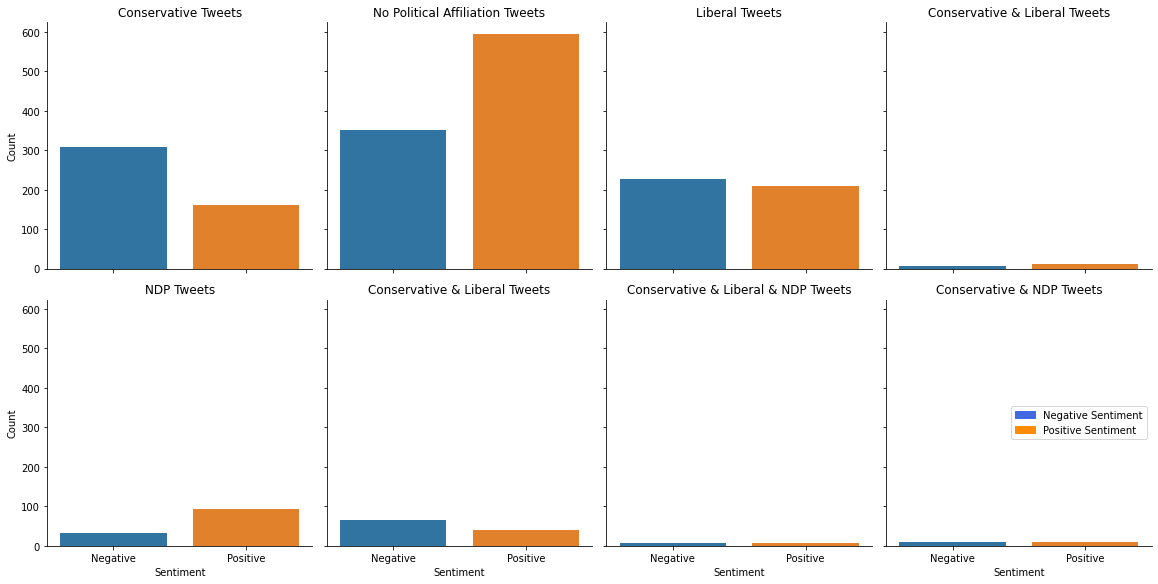

Text(0.5, 0.98, 'Car Weight vs. Horsepower')

In [ ]:
plt.figure(figsize = (15,8))
fig = sns.catplot(x="label",  col="party_score",
                data=elec_df, kind="count",
                height=4, aspect=1, col_wrap = 4, legend = True)

axes = fig.axes.flatten()
axes[0].set_title("Conservative Tweets")
axes[1].set_title("No Political Affiliation Tweets")
axes[2].set_title("Liberal Tweets")
axes[3].set_title("Conservative & Liberal Tweets")
axes[4].set_title("NDP Tweets")
axes[5].set_title("Conservative & Liberal Tweets")
axes[6].set_title("Conservative & Liberal & NDP Tweets")
axes[7].set_title("Conservative & NDP Tweets")
fig.set_axis_labels(x_var = 'Sentiment', y_var = 'Count')
fig.set_xticklabels(labels = ['Negative', 'Positive'])

import matplotlib.patches as mpatches
negative = mpatches.Patch(color='royalblue', label='Negative Sentiment')
positive = mpatches.Patch(color='darkorange', label='Positive Sentiment')
plt.legend(handles=[negative, positive], loc = 'right')
plt.show()
fig.fig.suptitle("Car Weight vs. Horsepower")


We can see the true sentiment of the 2019 Elections Data tweets seperated by their affiliation with political party above. The political party was determined using the procedure as described above. We see that the Conservatives had a significantly higher number of negative sentiment tweets compared to other groups. The Liberal tweets were nearly equal with there being slightly more negative sentiment tweets. The NDP had the best results with a higher number of positive sentiment tweets. With regard to tweets related to multiple parties they always had more negative than positive sentiment tweets. Of tweets with no political affiliation they were mostly positive sentiments. This would suggest that political tweets in general are usually of negative sentiment in the Canada 2019 Elections. 



####Predicted Sentiments

<Figure size 1080x576 with 0 Axes>

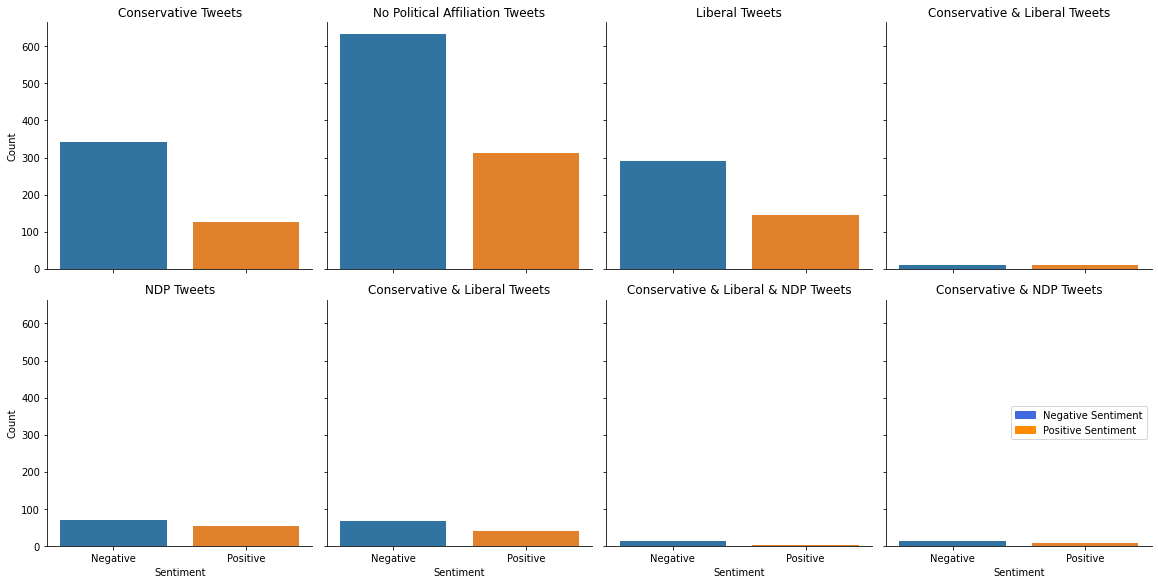

In [ ]:
plt.figure(figsize = (15,8))
fig = sns.catplot(x="pred_label",  col="party_score",
                data=elec_df, kind="count",
                height=4, aspect=1, col_wrap = 4, legend = True)

axes = fig.axes.flatten()
axes[0].set_title("Conservative Tweets")
axes[1].set_title("No Political Affiliation Tweets")
axes[2].set_title("Liberal Tweets")
axes[3].set_title("Conservative & Liberal Tweets")
axes[4].set_title("NDP Tweets")
axes[5].set_title("Conservative & Liberal Tweets")
axes[6].set_title("Conservative & Liberal & NDP Tweets")
axes[7].set_title("Conservative & NDP Tweets")
fig.set_axis_labels(x_var = 'Sentiment', y_var = 'Count')
fig.set_xticklabels(labels = ['Negative', 'Positive'])

import matplotlib.patches as mpatches
negative = mpatches.Patch(color='royalblue', label='Negative Sentiment')
positive = mpatches.Patch(color='darkorange', label='Positive Sentiment')
plt.legend(handles=[negative, positive], loc = 'right')
plt.show()

We can see that our predicted tweets are relatively accurate for the tweets that are affiliated with a political party. However for prediction of tweets with no political affiliation the model severely over predicts negative sentiment. This over-prediction appears for the other political parties although it is less severe. 





####Summary

In summary I think NLP analytics based on tweets is useful for political parties during election campaigns as it gives insight into the public opinion on their party. Additionally through further analysis such as the use of word clouds to find key words, we can find the hot topic issues that are trending on Twitter and can devise strategies for political purposes. It is also a useful tool for gauging public opinion on new policies or actions undertaken by the party which can help with PR and getting re-elected. 

#Model Implementation: Elections 2019 Data Sentiment Reason Prediction

Seperate the negative tweets and do some exploration on the distribution of negative reasons.

In [ ]:
neg_elec_tweets_df = elec_df[elec_df.sentiment == 'negative']
neg_elec_text = neg_elec_tweets_df.text_cleaned
neg_elec_reason = neg_elec_tweets_df.negative_reason

In [ ]:
neg_elec_tweets_df.negative_reason.value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

We see that the majority of negative reasons are listed as 'Others'. The second most frequent class is 'Scandal' while the third is 'Tell Lies'. Of the remaining reasons they are 51 or less so it would make sense to combine them if they are similar. Women's Reproductive right is similar to Healthcare which is also similar to Healthcare and Marijuana so we will combine these reasons. The classes we will combine together (Separation, Priviledge, Climate) because they are so small and would be even smaller once split into train/test (even could not be in training at all).

In [ ]:
reasons_map = {'Others': 0, 'Scandal': 1, 'Tell lies': 2, 'Economy':3, 'Women Reproductive right and Racism':4, 'Healthcare': 4, 'Healthcare and Marijuana':4, 'Climate Problem':5, 'Separation':0, 'Privilege': 0}
neg_elec_reason = neg_elec_reason.map(reasons_map)

In [ ]:
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(neg_elec_text, neg_elec_reason, test_size=0.30, random_state=10)


In [ ]:
vectorizer_neg = CountVectorizer(analyzer = "word",ngram_range = (1,1), max_features = 1000, strip_accents = 'ascii') 
vectorizer_neg.fit([' '.join(arr) for arr in X_train_neg])

bag_of_words_train_neg = vectorizer_neg.transform([' '.join(arr) for arr in X_train_neg])
bag_of_words_test_neg = vectorizer_neg.transform([' '.join(arr) for arr in X_test_neg])

I will choose the top 3 models which had the highest accuracy and use those on the Canadian Elections tweets data. I will use bag of words as the vectorizer given they are approximately equal accuracy between the two.

##Logistic Regression


We will train the model using logistic regression but also use hyperparameter tuning. We will use vary the value of C to prevent overfitting, try multiple solvers which work well for large sparse datasets and we will only use L2 for the same reason. 

- C is the inverse regularization parameter which inversely increases the strength of regularization. We choose a random from 0.01 to 1 to find the optimal regularization to prevent overfitting while allowing the model to learn effectively. 

L1 regularization was run and found to be worse than L2 regularzation however it is not included below as it produces many FitFailedWarnings given it is not compatible with various solvers we are attempting to use. 

In [ ]:
log_reg_bow_neg = LogisticRegression()
parameters_logistic_reg = {'C': np.linspace(0.01,1,num=10), 'solver' : ['lbfgs','saga'], 'penalty':['l2'], 'max_iter' : [5000]}
log_reg_bow_neg_CV = GridSearchCV(log_reg_bow_neg, parameters_logistic_reg)
log_reg_bow_neg_CV.fit(bag_of_words_train_neg, y_train_neg)

log_bow_test_pred_neg = log_reg_bow_neg_CV.predict(bag_of_words_test_neg)

log_bow_test_acc_neg = accuracy_score(y_test_neg,log_bow_test_pred_neg)
print('The accuracy using Logistic Regression with BoW on the test set is:', 100*np.round(log_bow_test_acc_neg,4), '%')


The accuracy using Logistic Regression with BoW on the test set is: 49.01 %


##Naive Bayes

For Naive Bayes we will adjust various hyperparameters as shown below and test using GridSearchCV to find the optimal hyperparameters for accuracy.

- C is the inverse regularization parameter which inversely increases the strength of regularization. We choose a random from 0.01 to 1 to find the optimal regularization to prevent overfitting while allowing the model to learn effectively. 

- We only use L2 regularization penalty as the L1 is not suitable for sparse matrics and leads to coef_ vectors that are sparse. Additionally many loss functions are not supported with L1.

We increase the number of iterations to 5000 from the default of 1000 to ensure convergence. 

In [ ]:
svm_linear_bow_neg = LinearSVC()
parameters_svm_linear = {'C': np.linspace(0.01,1,num=10), 'penalty':['l2'], 'max_iter' : [5000]}
svm_linear_bow_neg_CV = GridSearchCV(svm_linear_bow_neg, parameters_svm_linear)
svm_linear_bow_neg_CV.fit(bag_of_words_train_neg, y_train_neg)

svm_linear_bow_test_pred_neg = svm_linear_bow_neg_CV.predict(bag_of_words_test_neg)

svm_linear_bow_test_acc_neg = accuracy_score(y_test_neg, svm_linear_bow_test_pred_neg)
print('The accuracy using Naive Bayes Classification with BoW on the test set is:', 100*np.round(svm_linear_bow_test_acc_neg,4), '%')



The accuracy using Naive Bayes Classification with BoW on the test set is: 51.32 %


##Random Forest

For random forest we will adjust various hyperparameters as shown below and test using GridSearchCV to find the optimal hyperparameters for accuracy.

- max_depth is the maximum depth of the tree. The more depth in the tree, the more splits it has and it captures more information about the data. We fit each decision tree with either a depth of 10, 20 or None which means it will split the information until the nodes are less than the min_samples_split value which is also a hyperparameter we are adjusting. 

- max_features is the number of features including when looking for the best split. We clearly have very many potential features in the data so we will use either auto which means we use sqrt(n_features) as the max_features or log2 which is the log2(n_features). 

- min_samples_leaf is the minimum number of samples required to be at a leaf node and affects the size of the base of the tree. This is especially important when the max_depth is on None. A smaller value would result in a wider tree whereas a larger value would result in a skinnier tree. 

- min_samples_split determines the number of samples required to split an internal node. Larger values may vause the model not to learn enough from the data which causes underfitting. 

- n_estimators affects the number of trees used in the forest. Typically the greater the number of trees the better the learning. However there is a computational expense as a result of using too many trees so we will try to find a sweet spot. 

In [ ]:
ran_forest_bow_neg = RandomForestClassifier()
parameters_ran_forest = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,200,300]}

ran_forest_bow_neg_CV = GridSearchCV(ran_forest_bow_neg,parameters_ran_forest )
ran_forest_bow_neg_CV.fit(bag_of_words_train_neg, y_train_neg)

ran_forest_tfidf_test_pred_neg = ran_forest_bow_neg_CV.predict(bag_of_words_test_neg)

ran_forest_tfidf_test_acc_neg = accuracy_score(y_test_neg, ran_forest_tfidf_test_pred_neg)
print('The accuracy using Random Forest with BoW on the test set is:', 100*np.round(ran_forest_tfidf_test_acc_neg,4), '%')


The accuracy using Random Forest with BoW on the test set is: 58.60999999999999 %


In [ ]:
ran_forest_tfidf_test_pred_neg

array([1, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 5, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 5, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 5, 1, 5, 0, 1, 0, 0, 0, 1, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 3, 1, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 1, 0,
       1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 4, 0, 0, 2, 3, 2, 1,
       1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 5, 1, 4, 0, 0, 2, 1, 4, 0, 3, 1, 0,
       2, 5, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 4, 0, 1, 0, 0, 2, 1, 1, 1,
       0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 5,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 5, 0, 0, 0, 0, 2, 0, 1,

##Summary

The best model after hyperparameter tuning using GridSearchCV is RandomForest which was also the best model on the generic tweet dataset. It had a relatively higher accuracy compared to the other two models at 59%. However the overall model accuracy is not very high especially when compared to model performance on the generic tweet dataset which had accuracies above 90%. 


As discussed in the previous section sentiment analysis on tweets can be very useful to judge the political landscape of the Canadian Elections in 2019. You are able to see what the sentiment is towards various political parties, political leaders as shown from the results of the previous section.

#Results

 **“What can
public opinion on Twitter tell us about the Canadian political landscape in 2019?”**



The Canadian political landscape in 2019 was in general viewed with a stronger negative sentiment than a positive one. This is seen by the larger proportion of negative sentiment tweets when related to a political party. Additionally it was found that the Conservative party had the largest proportion of negative sentiment tweets and these were largely related to Women's Healthcare (abortion) and Racism which were hot topics during their campaigns. The Conservative party is typically pro-life and so there was lots of negative backlash over Twitter. Additionally the conservative party has had racist instances in the past which also caused this negative sentiment. The Liberal Party also had a larger number of negative sentimet tweets and these were primarily targeted at Justin Trudeau and the SNC 'scandal'. The NDP was the only party which had more positive sentiment tweets however their overall number of tweets was less than both parties. This provides us with a lot of insight of the public sentiment towards the parties on twitter and the general reasons for these sentiments which can be extracted from keywords and a word cloud. Further data exploration of the elections tweet data can be done.

Based on the results of this election it coincides with the sentiment analysis of election tweets given that Liberals had the least negative sentiment while also being more popular than the NDP. The conservatives were popular but had many more negative sentiment tweets. 

For our first model we attempted to predict the sentime of the elections tweets. We used the model which provided the best accuracy from the generic tweet dataset which was a Random Forest classifier with TF-IDF vectorized data. The model did not perform as well as it did on the generic test data with an accuracy of approximately 60%. In particular the model had difficulty predicting positive tweets correctly. The positive election tweets don't have discerning key words such as Love or Happy as we saw in the word cloud. This could be further confirmed by creating a word cloud for the positive and negative election tweets. Below is an example of a positive tweet which as you can see doesn't have any general words which carry positive sentiment. Rather, it is a very specific message with context (information outside of the model) which conveys a positive message. In this case it is complimenting governance of the Liberal Party. This is something that the model couldn't learn from generic tweet data. One way to improve accuracy of the model would be to train on Election Tweets. If not available for Canadian elections perhaps from other countries as it could learn various related keywords. 

In [ ]:
elec_df[elec_df.sentiment == 'positive'].text_cleaned.iloc[3]

['cdnpoli',
 'elxn43',
 'liberal',
 'double',
 'promised',
 '2015',
 'national',
 'debt',
 'next',
 'term',
 'elected',
 'forecasting',
 '90',
 'billion',
 'national',
 'pharmacare',
 'program',
 'incl',
 'ndp',
 'coalition',
 '180',
 'billion',
 'seems',
 'possible',
 'imo']

This wasn't as big of an issue for negative sentiment tweets as there are a lot more general keywords used such as Lied, cheater, death as shown in the tweet below. These words convey negative sentiment without the need for context as was the issue for positve sentiment tweets. 

In [ ]:
elec_df[elec_df.sentiment == 'negative'].text_cleaned.iloc[25]

['resists',
 'gill',
 'godwin',
 'name',
 'one',
 'election',
 'since',
 'harper',
 'mackay',
 'shook',
 'hand',
 'death',
 'pc',
 'pay',
 'cpc',
 'hasn',
 'lied',
 'cheated',
 'cdnpoli',
 'elxn43']

Of the negative elections tweets we created a multi-class classification model to predict the reason for the negative tweets. 3 different models were used (Logistic Regression, Naive Bayes, Random Forest) and their results after hyperparameter tuning were compared. The Random Forest model achieved the best result with an accuracy of approximately 60%. This result is relatively low. One reason for this is there are many classes with very few labels (less than 50) and so in the training split there is even less to train on. As shown below there are vew few

In [ ]:
neg_elec_reason.value_counts()

0    392
1    270
2    198
4     54
3     51
5     41
Name: negative_reason, dtype: int64

In [ ]:
neg_reason_df = pd.DataFrame(data = y_test_neg)
neg_reason_df['negative_reason_pred'] = ran_forest_tfidf_test_pred_neg
print(accuracy_score(neg_reason_df[neg_reason_df.negative_reason == 0].negative_reason, neg_reason_df[neg_reason_df.negative_reason == 0].negative_reason_pred))
print(accuracy_score(neg_reason_df[neg_reason_df.negative_reason == 1].negative_reason, neg_reason_df[neg_reason_df.negative_reason == 1].negative_reason_pred))
print(accuracy_score(neg_reason_df[neg_reason_df.negative_reason == 2].negative_reason, neg_reason_df[neg_reason_df.negative_reason == 2].negative_reason_pred))
print(accuracy_score(neg_reason_df[neg_reason_df.negative_reason == 3].negative_reason, neg_reason_df[neg_reason_df.negative_reason == 3].negative_reason_pred))
print(accuracy_score(neg_reason_df[neg_reason_df.negative_reason == 4].negative_reason, neg_reason_df[neg_reason_df.negative_reason == 4].negative_reason_pred))
print(accuracy_score(neg_reason_df[neg_reason_df.negative_reason == 5].negative_reason, neg_reason_df[neg_reason_df.negative_reason == 5].negative_reason_pred))


0.8090909090909091
0.5454545454545454
0.43283582089552236
0.23529411764705882
0.23076923076923078
0.5555555555555556


We see that the Others group had a relatively good accuracy. Of the remaining groups the ones with larger number of samples (Scandal and Tell Lies) did better than those with few samples. The worst result of 23% accuracy were for Economy which had only 51 data points as well as our grouped category which contained Women Reproductive right and Racism, Healthcare, Healthcare and Marijuana. It appears that those groups with larger sample sizes performed better which makes sense since the more data there is the more effecitvely the model can learn. One way to improve this model would be to use more advanced modelling techniques such as neural nets or word embeddings. Another method to improve the data is to adjust the groupings for negative reasons such that it maximizes accuracy. However we would have to be careful to match groups that make sense together. One reason our grouped category did not perform well is because they are meant to be seperate and don't have distinguishable keywords. This could be solved if we had more data for these negative reasons.

#Bonus 

##Further Data Visualization Elections Tweet Data

In [ ]:
elec_df['text_cleaned'][elec_df.label == 1]


1       [allwomanspacewalk, real, space, station, etob...
3       [canada, canadaelection2019, canadavotes, elxn...
6       [cdnmedia, elxn43, cdnpoli, ppc, rocky, dong, ...
7       [cdnpoli, elxn43, liberal, double, promised, 2...
10      [elxn43, two, day, away, voting, day, read, pr...
                              ...                        
2120    [absolutely, correct, priya, canadian, medium,...
2123    [miltonon, make, cancer, sexy, lady, lraitt, e...
2127    [heard, first, head, figure, aligns, best, val...
2130    [daily, reminder, thejagmeetsingh, endorses, s...
2132                                  [zing, ndp, elxn43]
Name: text_cleaned, Length: 1127, dtype: object

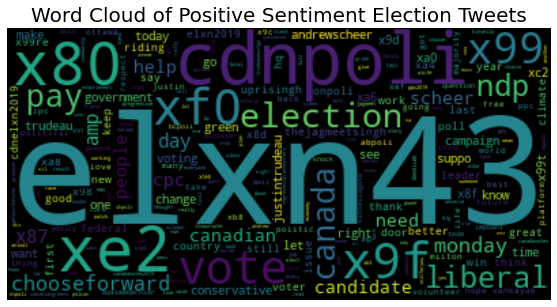

In [ ]:
pos_elec_tweets = elec_df['text_cleaned'][elec_df.label == 1]
tweets_string_pos_elec = []
for sentence in pos_elec_tweets:
    for word in sentence:
        tweets_string_pos_elec.append(word)
tweets_string_pos_elec = pd.Series(tweets_string_pos_elec).str.cat(sep=' ')

wordcloud_sen_elec_pos = WordCloud(max_font_size=250, max_words=250, collocations= False, background_color = 'black').generate(tweets_string_pos_elec)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_sen_elec_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Positive Sentiment Election Tweets', fontsize = 20)
plt.show()

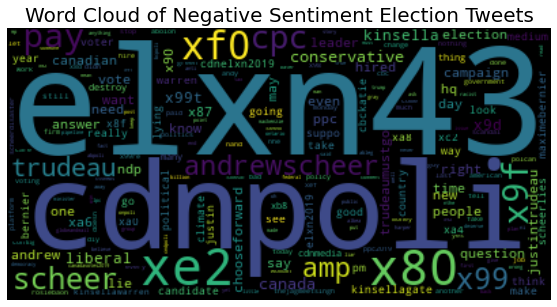

In [ ]:
neg_elec_tweets = elec_df['text_cleaned'][elec_df.label == 0]
tweets_string_neg_elec = []
for sentence in neg_elec_tweets:
    for word in sentence:
        tweets_string_neg_elec.append(word)
tweets_string_neg_elec = pd.Series(tweets_string_neg_elec).str.cat(sep=' ')

wordcloud_sen_elec_pos = WordCloud(max_font_size=250, max_words=250, collocations= False, background_color = 'black').generate(tweets_string_neg_elec)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_sen_elec_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Negative Sentiment Election Tweets', fontsize = 20)
plt.show()

We can see from the graphs above there was a lot more noise that was missed in the cleaning step due to the mass number of links in the election dataset. We had many 3 letter x__ words which don't contribute to sentiment analysis and instead add noise which could make the model perform worse. Additionally we see that many of the positive and negative sentiment keywords are the same. This could explain why our model had a tough time distinguishing between sentiments. Also we see the keywords for both positive and negative sentiment tweets are not similar to those in the generic tweet dataset. They appear to be very specific words related to the topic of the Canadian elections rather than generic positive or negative words. This could be another reason to explain why our model trained on the generic tweets could not perform very well on the elections data. Rather it would be better to train a model that on Canadian elections tweets. Also the hashtags should have been removed which appear in both sentiments such as 'elxn43' or 'cdnpoli'.